# Laboratorio 1: Clasificación Binaria (Ciencia de Datos)

**Objetivo de aprendizaje:** aplicar el ciclo de modelado supervisado para un problema de **clasificación binaria** con **desbalance de clases**, utilizando `pandas`, `scikit-learn` y métricas apropiadas.

**Entregables:**
1. Notebook completo y ejecutado (con celdas, gráficos y conclusiones).
2. Un breve informe con: problema, método, resultados y discusión (incluir pertinencia de métricas y trade-offs).
3. Tabla de comparación de modelos (base y final) con métricas en validación cruzada.

**Datos:** archivo `datos_clasificacion.csv` (provisto). Si no lo encuentras localmente, la notebook puede generar datos equivalentes.


## 0. Requisitos e instrucciones

- Usa Python 3.10+ con las librerías: `pandas`, `numpy`, `scikit-learn`, `matplotlib`.
- Trabaja con entorno reproducible (fija `random_state=42` cuando corresponda).
- No borres celdas; agrega las que necesites.
- Escribe **conclusiones** al final de cada sección.

---


In [ ]:
# %% [code]
# 1. Cargar datos
# Intenta leer el CSV. Si no existe (por ejemplo al ejecutar en otro entorno),

import os
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

DATA_PATHS = [
    "datos_clasificacion.csv",
    "./data/datos_clasificacion.csv",
    "/content/sample_data/datos_clasificacion.csv"
]

for p in DATA_PATHS:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Cargado: {p} - shape={df.shape}")
        break
else:
    print("No se encontró el CSV. Generando datos sintéticos...")

df.head()

Cargado: /content/sample_data/datos_clasificacion.csv - shape=(1200, 17)


,feat_00,feat_01,feat_02,feat_03,feat_04,feat_05,feat_06,feat_07,feat_08,feat_09,feat_10,feat_11,feat_12_poly,feat_13_abs,feat_14_noise,target,cat_band
0,0.615662,-0.323168,-0.137477,-2.333060,-1.858558,0.975872,-0.600356,0.268812,1.881126,-0.518638,1.718364,0.821691,-0.198962,0.137477,-0.494296,0,Q1
1,0.244224,-0.604030,-0.560556,-2.621269,1.253016,0.671979,-2.412987,0.219204,-0.070131,0.673429,0.161792,-0.061128,-0.147519,0.560556,-0.193851,1,Q1
2,1.695062,-0.247954,0.932332,-0.906390,-0.704487,1.082947,-3.411509,-0.479968,-1.059177,-0.515981,0.416873,3.463493,-0.420298,0.932332,-0.210323,1,Q3
3,-0.810494,0.529300,-1.508059,-2.394963,0.231068,1.756728,-0.886100,1.356107,0.337918,-0.500153,0.532022,-0.335240,-0.428995,1.508059,-0.027774,1,Q1
4,1.602021,-1.441910,-2.932393,-0.235706,-2.660589,2.810072,-0.292693,0.945930,0.621192,0.953176,0.789075,0.526275,-2.309971,2.932393,0.165632,0,Q4


## 2. Análisis exploratorio (EDA)

- Tamaño del dataset, tipos de datos, valores faltantes.
- Distribución de la variable objetivo (¿hay desbalance?).
- Estadísticos descriptivos y correlaciones (cuidado con *leakage*).
- 2–3 gráficos relevantes (histogramas, boxplots, distribución por clase, etc.).


Shape: (1200, 17)

Tipos:
feat_00          float64
feat_01          float64
feat_02          float64
feat_03          float64
feat_04          float64
feat_05          float64
feat_06          float64
feat_07          float64
feat_08          float64
feat_09          float64
feat_10          float64
feat_11          float64
feat_12_poly     float64
feat_13_abs      float64
feat_14_noise    float64
target             int64
cat_band          object
dtype: object

Valores faltantes por columna:
feat_00          0
feat_01          0
feat_02          0
feat_03          0
feat_04          0
feat_05          0
feat_06          0
feat_07          0
feat_08          0
feat_09          0
feat_10          0
feat_11          0
feat_12_poly     0
feat_13_abs      0
feat_14_noise    0
target           0
cat_band         0
dtype: int64

Distribución objetivo:
target
0    0.696667
1    0.303333
Name: proportion, dtype: float64


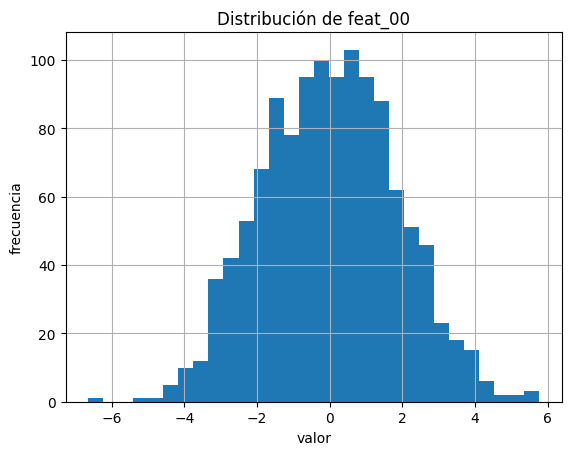

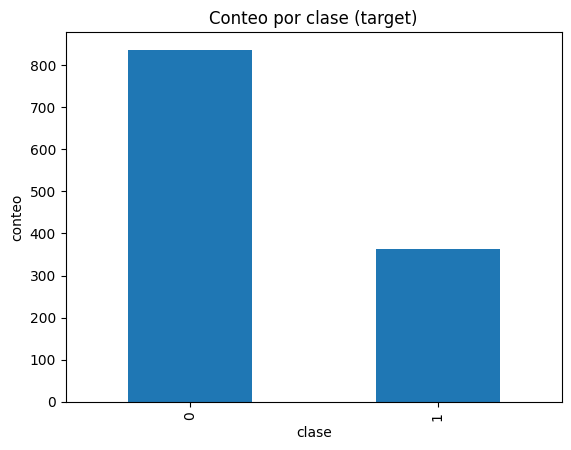

In [ ]:
# %% [code]
import matplotlib.pyplot as plt

print("Shape:", df.shape)
print("\nTipos:")
print(df.dtypes)

print("\nValores faltantes por columna:")
print(df.isna().sum())

print("\nDistribución objetivo:")
print(df['target'].value_counts(normalize=True))

# Histograma de una característica continua
df['feat_00'].hist(bins=30)
plt.title("Distribución de feat_00")
plt.xlabel("valor")
plt.ylabel("frecuencia")
plt.show()

# Distribución objetivo
df['target'].value_counts().plot(kind='bar')
plt.title("Conteo por clase (target)")
plt.xlabel("clase")
plt.ylabel("conteo")
plt.show()


## 3. Partición de datos

- Separa en `train`/`test` (estratificado).
- Considera asignar un conjunto de validación con CV en `train`.


In [ ]:
# %% [code]
from sklearn.model_selection import train_test_split

features = [c for c in df.columns if c not in ['target']]
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((960, 16), (240, 16))

## 4. Preprocesamiento y pipeline

- Separa numéricas y categóricas.
- Crea un `ColumnTransformer` con escalado para numéricas y OneHot para categóricas.

> Nota: en todo flujo moderno de machine learning con datos heterogéneos, se puede preprocesar diferentes tipos de columnas en paralelo dentro de un mismo pipeline usando`ColumnTransformer`
- Arma un **pipeline** con un modelo base (p. ej., Regresión Logística).


In [ ]:
# %% [code]
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = X_train.select_dtypes(include=['float64','float32','int64','int32']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

log_reg = LogisticRegression(max_iter=200, class_weight=None, random_state=42)

pipe_base = Pipeline(steps=[
    ('prep', preprocess),
    ('model', log_reg)
])

pipe_base


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['feat_00', 'feat_01',
                                                   'feat_02', 'feat_03',
                                                   'feat_04', 'feat_05',
                                                   'feat_06', 'feat_07',
                                                   'feat_08', 'feat_09',
                                                   'feat_10', 'feat_11',
                                                   'feat_12_poly',
                                                   'feat_13_abs',
                                                   'feat_14_noise']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cat_band'])])),
                ('model', LogisticRegression(max_iter=200, random_state=42))])

## 5. Métricas y evaluación

- Usa `accuracy`, `precision`, `recall`, `f1` y `roc_auc`.
- Muestra matriz de confusión y curva ROC.
- Comenta por qué algunas métricas son más adecuadas con desbalance.


Accuracy: 0.85
Precision: 0.8627450980392157
Recall: 0.6027397260273972
F1: 0.7096774193548387
ROC AUC: 0.8931999015667295


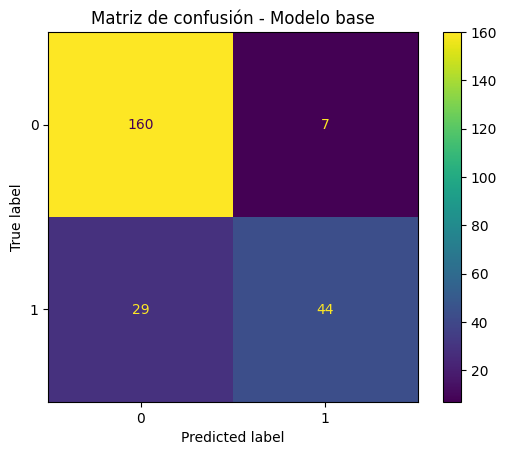

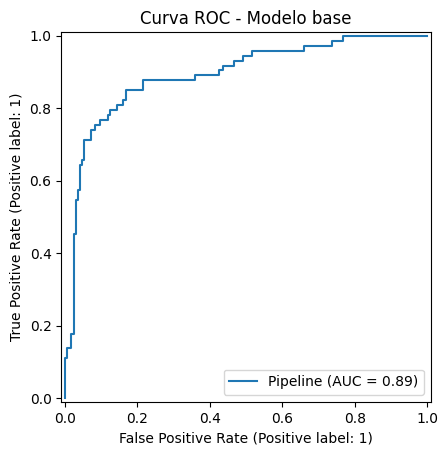

In [ ]:
# %% [code]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

pipe_base.fit(X_train, y_train)
y_pred = pipe_base.predict(X_test)
y_proba = pipe_base.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_estimator(pipe_base, X_test, y_test)
plt.title("Matriz de confusión - Modelo base")
plt.show()

RocCurveDisplay.from_estimator(pipe_base, X_test, y_test)
plt.title("Curva ROC - Modelo base")
plt.show()


## 6. Validación cruzada y comparación de modelos

- Evalúa con `StratifiedKFold` y `cross_validate`.
- Compara al menos **3** modelos: Regresión Logística, Árboles/AdaBoost/RandomForest o SVM.
- Reporta métricas promedio y desviación estándar.


## 8. Evaluación final en Test

- Evalúa el **mejor modelo** en el conjunto de prueba.
- Calcula métricas, matriz de confusión, curva ROC.
- Discute errores y posibles mejoras.


## 10. Informe y conclusiones (para entregar)

Redacta un breve informe que incluya:

- **Problema** (formulación y supuestos).
- **Método** (preprocesamiento, modelos, CV, métricas).
- **Resultados** (tabla comparativa y desempeño final en test).
- **Discusión** (interpretación, trade-offs de métricas, impacto del umbral, riesgos de *overfitting* y *data leakage*).
- **Trabajo futuro** (qué harías para mejorar).
